In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, RFE
import yfinance as yf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import itertools

[*********************100%***********************]  1 of 1 completed


Cumulative Return: 135.8478


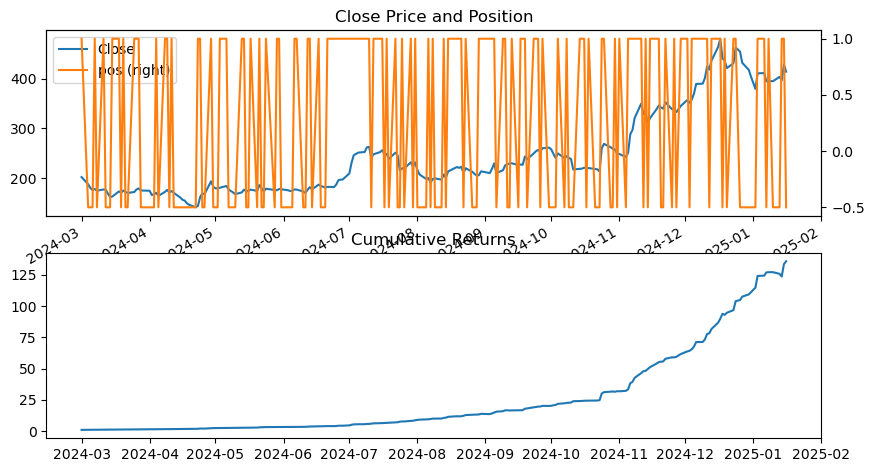

In [16]:
stock = 'TSLA'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def xgb_strategy(data):
    df1 = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    start_date = '2022-01-01'
    end_date = '2024-01-21'
    df2 = yf.download(stock, start=start_date, end=end_date)

    # Make sure data is sorted by date
    df2.sort_index(inplace=True)
    df2 = df2.droplevel(1, axis=1) 

    df = pd.concat((df2, df1)) 

    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Drop NaN values
    df.dropna(inplace = True)

    # Simple & Exponential Moving Averages
    df['SMA_10'] = df['Close'].rolling(window = 10).mean()
    df['SMA_50'] = df['Close'].rolling(window = 50).mean()
    df['EMA_20'] = df['Close'].ewm(span = 20, adjust = False).mean()

    # Bollinger Bands (20-day)
    rolling_mean = df['Close'].rolling(window = 20).mean()
    rolling_std = df['Close'].rolling(window = 20).std()
    df['boll_upper'] = rolling_mean + (2 * rolling_std)
    df['boll_lower'] = rolling_mean - (2 * rolling_std)

    # MACD & Signal Line
    df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD_signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    # Average True Range (ATR)
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window = 14).mean()

    # ADX (Directional Movement Index)
    df['DM_plus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                             np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DM_minus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                              np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['DI_plus'] = 100 * (df['DM_plus'].rolling(window = 14).mean() / df['ATR'])
    df['DI_minus'] = 100 * (df['DM_minus'].rolling(window = 14).mean() / df['ATR'])
    df['DX'] = (np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])) * 100
    df['ADX'] = df['DX'].rolling(window = 14).mean()

    # Stochastic Oscillator (14-day)
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window = 14).min()) /
                     (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * 100

    # Williams %R (14-day)
    df['williams_R'] = ((df['High'].rolling(window = 14).max() - df['Close']) /
                         (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * -100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)

    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Market Direction (Target)
    
    df['direction'] = (df['Returns'] > 0).astype(int)
        
    # Drop NaN values
    df.dropna(inplace = True)

    # Feature Selection Approaches
    features = [col for col in df.columns if col not in ['Returns', 'direction']]
    train_data = df.loc[:'2024-03-01'].copy()
    X = train_data[features]
    y = train_data['direction']

    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X, y, discrete_features = False)
    mi_selected_features = pd.Series(mi_scores, index = features).nlargest(10).index.tolist()

    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfe = RFE(rf, n_features_to_select = 10)
    rfe.fit(X, y)
    rfe_selected_features = X.columns[rfe.support_].tolist()

    # Select Top Features (Union of All Methods)
    final_selected_features = list(set(mi_selected_features) | set(rfe_selected_features))

    # Standardize Features
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train XGBoost Model
    model = XGBClassifier(eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Predict & Compute Strategy Returns
    predictions = model.predict(X_test)
    test_data['pos'] = np.where(predictions == 0, -0.5, 1)
    test_data['xgb_returns'] = test_data['pos'] * test_data['Returns']

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['xgb_returns'].sum())
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # Plot 'Close' and 'pos' with a secondary y-axis on the first subplot
    test_data[['Close', 'pos']].plot(ax=axes[0], secondary_y='pos')
    axes[0].set_title("Close Price and Position")

    # Plot the cumulative return on the second subplot
    axes[1].plot(np.exp(test_data['xgb_returns'].cumsum()))
    axes[1].set_title("Cumulative Returns")

    print(f"Cumulative Return: {cumulative_return:.4f}") 

xgb_strategy(src)

[*********************100%***********************]  1 of 1 completed


Cumulative Return: 540.3591


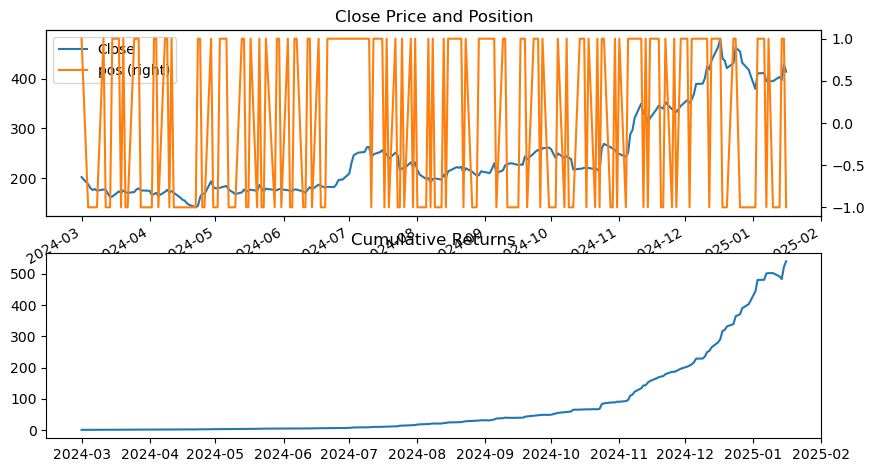

In [14]:
xgb_strategy(src)

In [4]:
stock = 'TSLA'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def LR_strategy(data_train = src, data_test = src):
    df_train = data_train.copy()
    df_test = data_test.copy()
    
    # Combine and preprocess both upfront for consistency
    data = pd.concat([df_train, df_test])
        
    df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Simple & Exponential Moving Averages
    df['SMA_10'] = df['Close'].rolling(window = 10).mean()
    # df['SMA_50'] = df['Close'].rolling(window = 50).mean()
    df['EMA_10'] = df['Close'].ewm(span = 10, adjust = False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_10'] / (df['EMA_10'] + 1e-10)

    # Bollinger Bands (20-day)
    rolling_mean = df['Close'].rolling(window = 20).mean()
    rolling_std = df['Close'].rolling(window = 20).std()
    df['boll_upper'] = rolling_mean + (2 * rolling_std)
    df['boll_lower'] = rolling_mean - (2 * rolling_std)

    # MACD & Signal Line
    df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD_signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    # Average True Range (ATR)
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window = 10).mean()

    # ADX (Directional Movement Index)
    df['DM_plus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                             np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DM_minus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                              np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['DI_plus'] = 100 * (df['DM_plus'].rolling(window = 10).mean() / df['ATR'])
    df['DI_minus'] = 100 * (df['DM_minus'].rolling(window = 10).mean() / df['ATR'])
    df['DX'] = (np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])) * 100
    df['ADX'] = df['DX'].rolling(window = 10).mean()

    # Stochastic Oscillator (14-day)
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window = 10).min()) /
                     (df['High'].rolling(window = 10).max() - df['Low'].rolling(window = 10).min())) * 100

    # Williams %R (14-day)
    df['williams_R'] = ((df['High'].rolling(window = 10).max() - df['Close']) /
                         (df['High'].rolling(window = 10).max() - df['Low'].rolling(window = 10).min())) * -100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    
    # Aroon
    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)
    
    # Differences between High, Low, Open, Close
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    
    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)

    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Market Direction (Target)
    df['direction'] = np.where(df['Returns'] >= -0, 1, 0)

    # Drop NaN values
    df.dropna(inplace = True)
 
    # Select Top Features (Union of All Methods)
    final_selected_features = ['low_close', 'high_close', 'stoch_k', 'High-Close', 'DX', 'williams_R', 'Aroon_Down', 'DM_minus', 'lag_1', 'High-Low', 'Low-Close', 'TrueRange', 'DM_plus']
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-03-01'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train XGBoost Model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict & Compute Strategy Returns
    test_data['pos'] = model.predict(X_test)
    test_data['pos'] = np.where(test_data['pos']==0, -0.5, test_data['pos'])
    test_data['strat_returns'] = test_data['pos'].shift(1) * test_data['Returns']
    
    train_data['pos'] = train_data['direction']
    
    result = pd.concat([train_data, test_data], ignore_index=False)
    result[['Close', 'High', 'Open', 'Low', 'Volume', 'Returns', 'pos', 'strat_returns']].to_csv("TSLA_complete.csv", index=True)

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['strat_returns'].sum())
    print(f"Cumulative Return: {cumulative_return:.4f}")

In [19]:
LR_strategy(src.loc[:'2024-03-01'], src.loc['2024-03-01':])

Cumulative Return: 352.8698


In [50]:
stock = 'TSLA'
data = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def sma_and_volume_strategy(df):
    # Calculate Log Returns
    df['returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df.dropna(inplace=True)

    # Calculate VWAP (Volume Weighted Average Price)
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3  # Typical Price
    df['Cumulative_TP_Volume'] = (df['TP'] * df['Volume']).cumsum()
    df['Cumulative_Volume'] = df['Volume'].cumsum()
    df['VWAP'] = df['Cumulative_TP_Volume'] / df['Cumulative_Volume']

    # Calculate OBV (On-Balance Volume)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Parameter Tuning Variables
    sma_windows = np.linspace(20, 50, 30).astype(int)  # Different SMA rolling periods to test
    volume_windows = np.linspace(10, 40, 30).astype(int)  # Different volume rolling periods to test

    best_params = None
    best_cumulative_return = -np.inf  # Track highest return

    # Loop through all SMA & Volume window combinations
    for sma_period, vol_period in itertools.product(sma_windows, volume_windows):

        # Apply indicators with selected rolling windows
        df['SMA'] = df['Close'].rolling(window = sma_period).mean()
        df['Volume_SMA'] = df['Volume'].rolling(window = vol_period).mean()

        # Buy & Sell Signals
        df['Buy_Signal'] = (df['Close'] > df['VWAP']) & (df['OBV'] > df['OBV'].shift(1)) & (df['Close'] > df['SMA']) & (df['Volume'] > df['Volume_SMA'])
        df['Sell_Signal'] = (df['Close'] < df['VWAP']) & (df['OBV'] < df['OBV'].shift(1)) & (df['Close'] < df['SMA']) & (df['Volume'] > df['Volume_SMA'])

        # Generate Position Column (1 for Buy, -1 for Sell, 0 otherwise)
        df['Position'] = np.where(df['Buy_Signal'], 1, np.where(df['Sell_Signal'], -1, 0))

        # Backtest Performance
        df['Strategy_Returns'] = df['Position'].shift(1) * df['returns']  # Shift position to avoid lookahead bias
        cumulative_return = (1 + df['Strategy_Returns']).cumprod().iloc[-1]  # Compute final portfolio value

        # Update Best Parameters if Current Combination Performs Better
        if cumulative_return > best_cumulative_return:
            best_cumulative_return = cumulative_return
            best_params = (sma_period, vol_period)

    # Display Best Parameters
    print(f"Best SMA Period: {best_params[0]}, Best Volume SMA Period: {best_params[1]}")
    print(f"Best Cumulative Return: {best_cumulative_return:.2f}")

    # Apply Best Parameters to Generate Final Trading Signals
    df['SMA'] = df['Close'].rolling(window = best_params[0]).mean()
    df['Volume_SMA'] = df['Volume'].rolling(window = best_params[1]).mean()
    df['Buy_Signal'] = (df['Close'] > df['VWAP']) & (df['OBV'] > df['OBV'].shift(1)) & (df['Close'] > df['SMA']) & (df['Volume'] > df['Volume_SMA'])
    df['Sell_Signal'] = (df['Close'] < df['VWAP']) & (df['OBV'] < df['OBV'].shift(1)) & (df['Close'] < df['SMA']) & (df['Volume'] > df['Volume_SMA'])

    df['Position'] = np.where(df['Buy_Signal'], 1, np.where(df['Sell_Signal'], -1, 1))

    

In [51]:
sma_and_volume_strategy(data)

Best SMA Period: 20, Best Volume SMA Period: 11
Best Cumulative Return: 1.29
                 Close        VWAP           OBV         SMA    Volume_SMA  \
Date                                                                         
2024-02-20  193.759995  190.722806 -2.950690e+07  191.066000  1.032753e+08   
2024-02-21  194.770004  190.931938  7.433710e+07  190.347501  1.005071e+08   
2024-02-22  197.410004  191.115399  1.670766e+08  189.826501  9.778557e+07   
2024-02-23  191.970001  191.196687  8.823470e+07  190.293501  9.481345e+07   
2024-02-26  199.399994  191.477434  1.999818e+08  191.101000  9.742374e+07   
...                ...         ...           ...         ...           ...   
2025-01-10  394.739990  236.385359  2.267438e+09  425.203499  7.836611e+07   
2025-01-13  403.309998  236.853594  2.335018e+09  424.130499  7.909599e+07   
2025-01-14  396.359985  237.467849  2.250454e+09  423.043498  7.984132e+07   
2025-01-15  428.220001  238.113419  2.331829e+09  422.642998  7.9